In [49]:
%matplotlib notebook
import numpy as np
import scipy.io as io
import sounddevice as sd
import scipy.signal as signal
import matplotlib.pyplot as pyplot
import numpy.fft as fft
import random
import numpy.random as npRand
import time

In [50]:
def spectogram(x, fs, win, winLen, overlap):
    f, t, Xft = signal.stft(x, fs, win, winLen, overlap)
    pyplot.figure()
    pyplot.pcolormesh(1000 * t, f, np.abs(Xft))
    
def loadMatSound(filename):
    return io.loadmat(filename)[filename.replace(".mat", "")][:, 0]

def genTones(tones, duration):
    Fs = 8000
    samples = round(Fs * duration)
    n = np.arange(samples)
    result = np.zeros(samples)
    
    for tone in tones:
        result += np.cos(2 * np.pi * tone * n / Fs)
        
    return result

replaceZeroes = np.vectorize(lambda t: 10 ** (-10) if t == 0 else t)

def plot_spectrum_t(x, fs, win, winLen, overlap, tPoint):
    f, t, Xft = signal.stft(x, fs, win, winLen, overlap)
    print(Xft.shape)
    timeIndex = None
    for i, ti in enumerate(t):
        if tPoint > ti:
            timeIndex = i
    
    timeIndex = timeIndex if tPoint - t[timeIndex] < t[timeIndex + 1] - tPoint \
    else timeIndex + 1
    
    X = replaceZeroes(np.abs(Xft[:, timeIndex]))
    pyplot.figure()
    pyplot.plot(f, np.abs(Xft[:, timeIndex]))
            
dtmfTable = {
    1:(697, 1209),
    2:(697, 1336),
    3:(697, 1477),
    "A":(697, 1633),
    4:(770, 1209),
    5:(770, 1336),
    6:(770, 1477),
    "B":(770, 1633),
    7:(852, 1209),
    8:(852, 1336),
    9:(852, 1477),
    "C":(852, 1633),
    "#":(941, 1209),
    0:(941, 1336),
    "*":(941, 1477),  
    "D":(941, 1633)
}

def dtmfEncoder(keys, toneDuration, silenceDuration):
    Fs = 8000
    result = None
    silence = np.zeros(round(Fs * silenceDuration))
    for key in keys:
        t = genTones(dtmfTable[key], toneDuration)
        if result is None:
            result = t
        else:
            result = np.concatenate((result, silence, t))
            
            
    return result

<IPython.core.display.Javascript object>


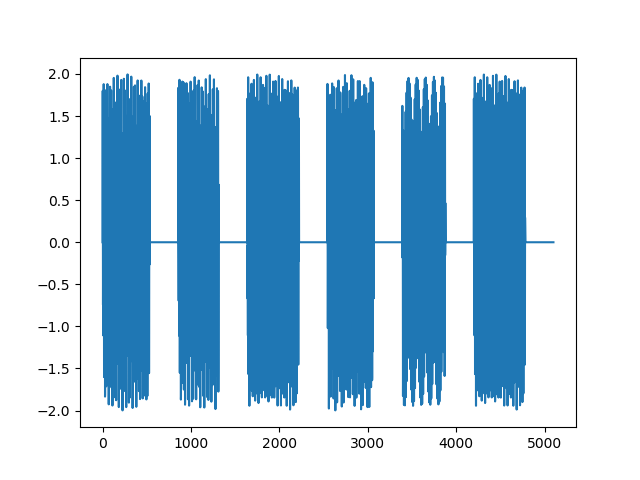

<IPython.core.display.Javascript object>


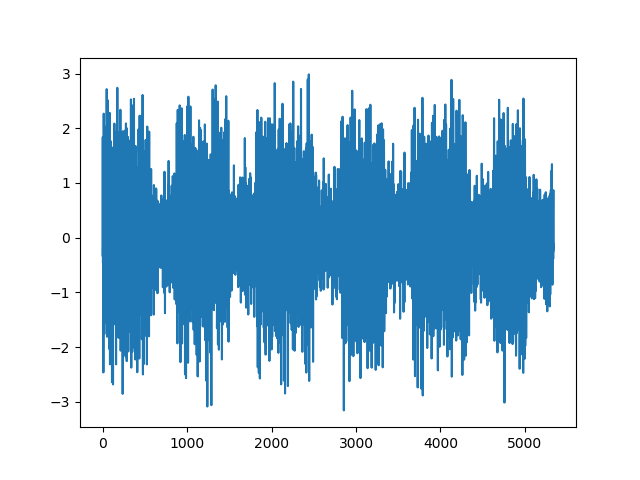

<IPython.core.display.Javascript object>


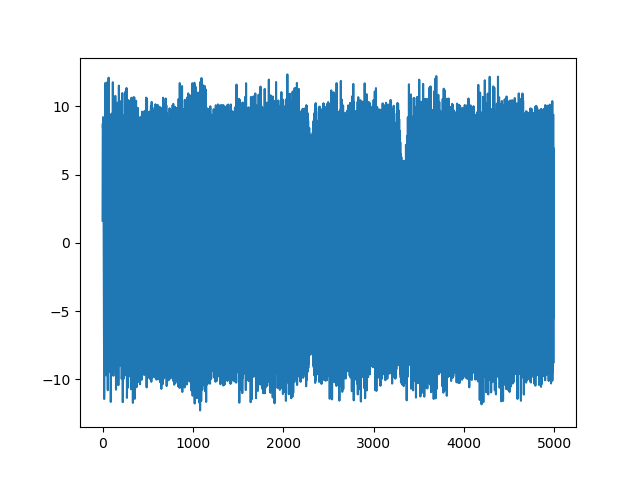

In [51]:
dtmf1 = loadMatSound("dtmf1.mat") # 519439
dtmf2 = loadMatSound("dtmf2.mat") # 221840
dtmf3 = loadMatSound("dtmf3.mat")
pyplot.figure()
pyplot.plot(dtmf1)
pyplot.figure()
pyplot.plot(dtmf2)
pyplot.figure()
pyplot.plot(dtmf3)
sd.play(dtmf2, 8000)

<IPython.core.display.Javascript object>


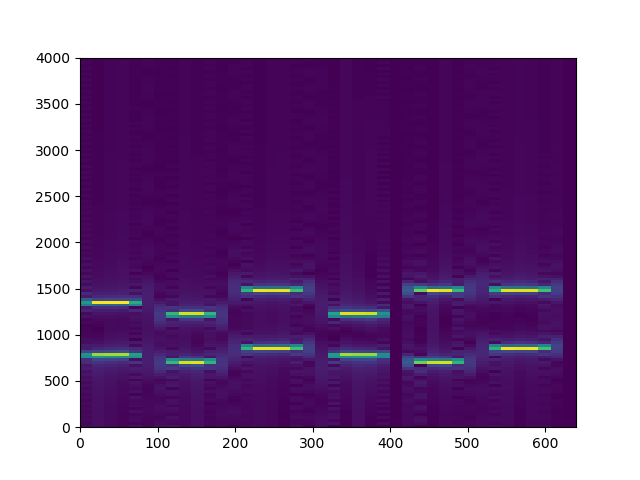

In [52]:
Fs = 8000
spectogram(dtmf1, Fs, "boxcar", 256, 128)
#plot_spectrum_t(dtmf1, Fs, "boxcar", 256, 128, 0.46)
#plot_spectrum_t(dtmf1, Fs, "boxcar", 256, 128, 0.18)
#plot_spectrum_t(dtmf1, Fs, "boxcar", 256, 128, 0.407)
#plot_spectrum_t(dtmf1, Fs, "boxcar", 256, 128, 0.36)

#spectogram(dtmf1, Fs, "boxcar", 2, 0)

<IPython.core.display.Javascript object>


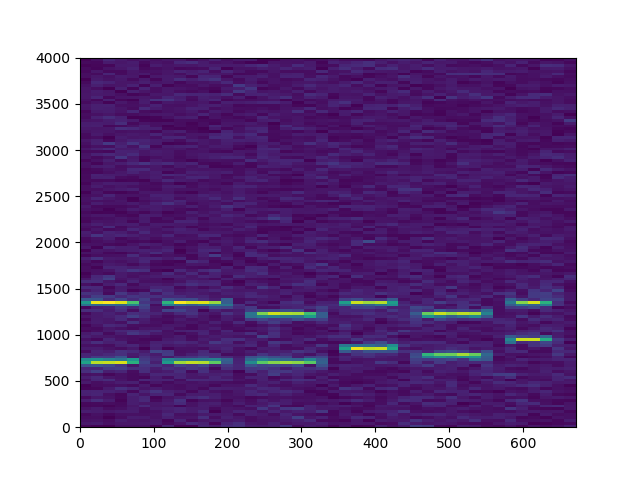

In [10]:
spectogram(dtmf2, Fs, "boxcar", 256, 128)

<IPython.core.display.Javascript object>


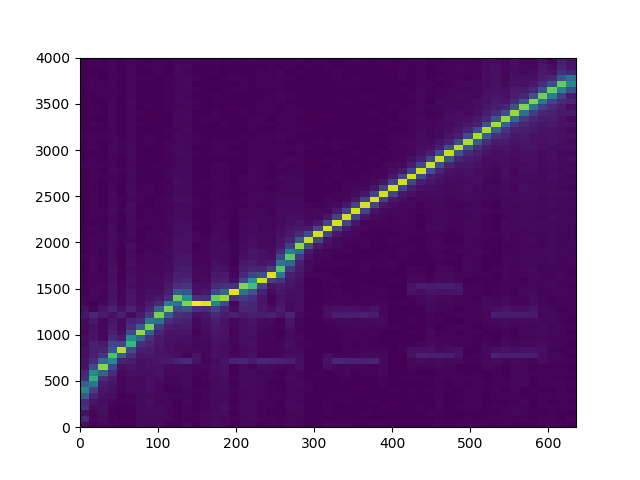

In [53]:
spectogram(dtmf3, Fs, "boxcar", 128, 32)

In [22]:
class DTMF:
    
    dtmfTable = {
    1:(697, 1209),
    2:(697, 1336),
    3:(697, 1477),
    "A":(697, 1633),
    4:(770, 1209),
    5:(770, 1336),
    6:(770, 1477),
    "B":(770, 1633),
    7:(852, 1209),
    8:(852, 1336),
    9:(852, 1477),
    "C":(852, 1633),
    "#":(941, 1209),
    0:(941, 1336),
    "*":(941, 1477),  
    "D":(941, 1633)
    }
    
    def __init__(self, minToneDuration = 0.04):
        self._keys = {}
        self._minToneDuration = minToneDuration
        for key in DTMF.dtmfTable:
            toneFft = fft.rfft(DTMF.genToneKey(DTMF.dtmfTable[key], 256), 256)
            toneFft = np.abs(toneFft) / np.amax(np.abs(toneFft))
            maxSim  = np.dot(toneFft, toneFft)
            self._keys[key] = (toneFft, maxSim) 
    
    def decode(self, x):
        freq, time, Zxx = signal.stft(x, 8000, "boxcar", 256, 128)
        keys = []
        timeAppeared = None
        lastKey = None
        Zxx = (np.abs(Zxx) / np.amax(np.abs(Zxx))).T
        for fftColumn, t in zip(Zxx, time):
            currKey = self.getKeyForFFT(fftColumn)
            #print(currKey)
            if lastKey is None and currKey is not None:
                timeAppeared = t
                lastKey = currKey
            elif lastKey != currKey:
                if t - timeAppeared > self._minToneDuration:
                    keys.append(lastKey)
                lastKey = currKey
                timeAppeared = t
                
        if time[-1] - timeAppeared > self._minToneDuration and lastKey != None:
            keys.append(lastKey)
            
        return keys
            
    def getKeyForFFT(self, fftColumn):
        similarity = {}
        for key, fftSimPair in self._keys.items():
            similarity[key] = np.dot(fftColumn, fftSimPair[0])
        
        # List of tuples of shape (key, similarity)
        result = sorted(similarity.items(), key = lambda keyValue: keyValue[1], reverse = True)
        
        #print(f"{result[0][0]} {result[0][1]}")
        decodedKey, sim = result[0][0], result[0][1]
           
        return decodedKey if sim > 0.5 * self._keys[decodedKey][1] else None
            
        
    @staticmethod
    def genToneKey(freqs, samples):
        Fs = 8000
        n = np.arange(samples)
        result = np.zeros(samples)
    
        for freq in freqs:
             result += np.cos(2 * np.pi * freq * n / Fs)
        
        return result
    

In [28]:
a = DTMF(0.03)
print(a.decode(dtmf1))
print(a.decode(dtmf2))
result = dtmfEncoder([0,5,1,3,8,0,6,1,7], 0.04, 0.01)
print(a.decode(result))
#spectogram(result, 8000, "boxcar", 256, 128)

[5, 1, 9, 4, 3, 9]
[2, 2, 1, 8, 4, 0]
[0, 5, 1, 3, 8, 0, 6, 1, 7]


In [54]:
dtmf = DTMF(0.03)
decodedCount = 0 # Num of succesful decoding
toDecode = 10000
decodeTime = 0
for n in range(toDecode):
    seq = random.choices(list(DTMF.dtmfTable.keys()), k = 6)
    toneDuration = random.uniform(0.04, 0.1)
    encodedSeq = dtmfEncoder(seq, 0.04, 0.04)
    #encodedSeq = encodedSeq + npRand.normal(0, 0.7477 ** 0.5, len(encodedSeq))
    startTime = time.perf_counter_ns()
    decodedSeq = dtmf.decode(encodedSeq)
    endTime = time.perf_counter_ns()
    decodeTime += endTime - startTime
    if seq != decodedSeq:
        print("Dekodovanje nije uspijelo")
        print(f"Dekodovano: {decodedSeq}, Enkodovano: {seq}")
        print(f"Trajanje tona: {toneDuration}")
    else:
        decodedCount += 1
print(f"Broj uspjesnih dekodovanja: {decodedCount}")
print(f"Broj neuspjesnih dekodovanja {toDecode - decodedCount}")
print(f"Procenat uspjesnosti: {decodedCount * 100 / toDecode}")
decodePerSec = decodedCount * 10 ** 9 / decodeTime
print(f"Broj dekodovanja u sekundi: {round(decodePerSec)}")
print(f"Trajanje jednog dekodovanja(u ms): {1000 / decodePerSec}")

Broj uspjesnih dekodovanja: 10000
Broj neuspjesnih dekodovanja 0
Procenat uspjesnosti: 100.0
Broj dekodovanja u sekundi: 855
Trajanje jednog dekodovanja(u ms): 1.16909853


<IPython.core.display.Javascript object>


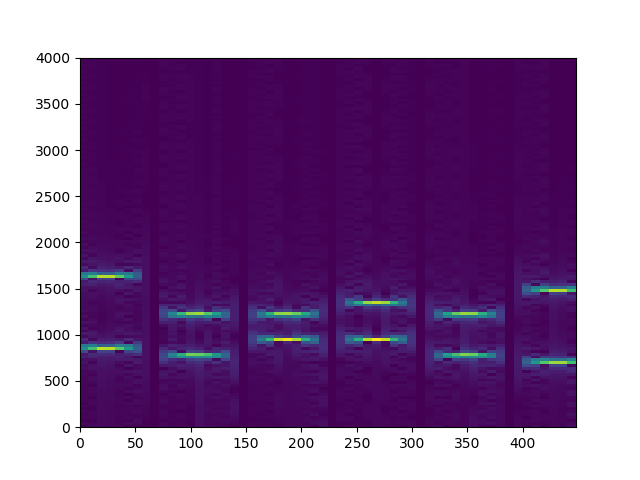

C
C
C
None
None
4
4
4
None
None
#
#
#
#
None
0
0
0
0
None
4
4
4
4
None
None
3
3
3
['C', 4, '#', 0, 4, 3]


In [442]:
dtmf = DTMF(0.03)
encodedSeq = dtmfEncoder(['C', 4, '#', 0, 4, 3], 0.04129608660451639, 0.04)
#pyplot.figure()
#pyplot.plot(encodedSeq)
spectogram(encodedSeq, 8000, "boxcar", 256, 192)
print(dtmf.decode(encodedSeq))